In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants.skeletons import CompliantTendonArm
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.losses import empty_loss, position_loss, activation_squared_loss
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

tensorflow version: 2.3.0


In [6]:
import sympy as sp
kse, kpe, lse, lpe, lce, lmt, lm = sp.symbols('kse, kpe, lse, lpe, lce, lmt, lm')

eq = kse * ((lmt - lm - lse) / lse) ** 2 - kpe * ((lm - lpe) / lce) ** 2
sp.solve(eq, lm)

[(kpe*lpe*lse**2 - kse*lce**2*lmt + kse*lce**2*lse - lce*lse*sqrt(kpe*kse)*(-lmt + lpe + lse))/(kpe*lse**2 - kse*lce**2),
 (kpe*lpe*lse**2 - kse*lce**2*lmt + kse*lce**2*lse + lce*lse*sqrt(kpe*kse)*(-lmt + lpe + lse))/(kpe*lse**2 - kse*lce**2)]

In [7]:
lmt = 1.
lce = .4
lpe = lce
lse = .4
kse = 1.
kpe = 2.
root1 = (kpe*lpe*lse**2 - kse*lce**2*lmt + kse*lce**2*lse - lce*lse*np.sqrt(kpe*kse)*(-lmt + lpe + lse))/(kpe*lse**2 - kse*lce**2)
root2 = (kpe*lpe*lse**2 - kse*lce**2*lmt + kse*lce**2*lse + lce*lse*np.sqrt(kpe*kse)*(-lmt + lpe + lse))/(kpe*lse**2 - kse*lce**2)


print(root1)
print(root2)

0.48284271247461896
-0.0828427124746189


In [8]:
new_activation = 0.025

norm_muscle_len = 1.
rho_factor = 1.37e-4 * 5.27e4 * (2.9 - 1)
rho = rho_factor * norm_muscle_len / (2.9 - norm_muscle_len)
cte = (rho * new_activation) ** 3
q = (5e-3 + cte) / (1 + cte)

print(q)

0.010816882200498739


simulation duration: 65.96899999999732 sec


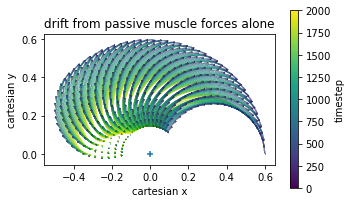

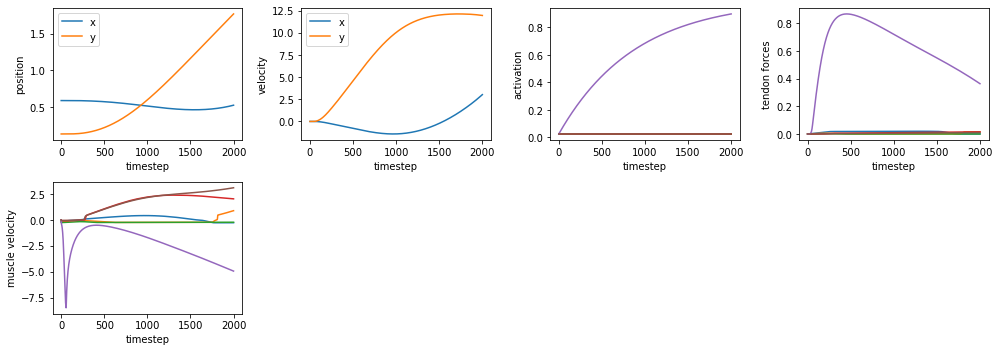

In [9]:

arm = CompliantTendonArm(timestep=0.0001, min_activation=0.025)

sho, elb = np.meshgrid(
    np.linspace(arm.pos_lower_bounds[0], arm.pos_upper_bounds[0], 21).astype('float32'),
    np.linspace(arm.pos_lower_bounds[1], arm.pos_upper_bounds[1], 21).astype('float32'))
z = tf.zeros_like(sho.reshape(-1))

ex = tf.ones((sho.size, arm.n_muscles)) * [0, 0, 0, 0, 1, 0]
state0 = arm.get_initial_state(skeleton_state=tf.stack([sho.reshape(-1), elb.reshape(-1), z, z], axis=1))
j_results = state0[0][:, tf.newaxis, :]
c_results = state0[1][:, tf.newaxis, :]
m_results = state0[-2][:, tf.newaxis, :, :]
states = state0

start = time.monotonic()
# 200 ms simulation to assess drift
for _ in range(int(0.2 / arm.dt)):
    states = arm(ex, states[0], states[-2], states[-1])
    j_results = tf.concat([j_results, states[0][:, tf.newaxis, :]], axis=1)
    c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)
    m_results = tf.concat([m_results, states[-2][:, tf.newaxis, :, :]], axis=1)
print('simulation duration: ' + str(time.monotonic() - start) + ' sec')

plt.figure(figsize=(5, 3)).set_tight_layout(True)
plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')


states[1] - state0[1]
mstate = state0[-2].numpy().reshape((21, 21, 6, 6))
gstate = state0[-1].numpy().reshape((21, 21, 4, 6))


#%

trial = 26
plt.figure(figsize=(14, 5)).set_tight_layout(True)

plt.subplot(241)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='x')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='y')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('position')

plt.subplot(242)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='x')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='y')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('velocity')

plt.subplot(243)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('timestep')
plt.ylabel('activation')

plt.subplot(244)
x= m_results[trial, :, 5, :]
plt.plot(x.numpy().squeeze())
plt.xlabel('timestep')
plt.ylabel('tendon forces')

plt.subplot(245)
x= m_results[trial, :, 2, :]
plt.plot(x.numpy().squeeze())
plt.xlabel('timestep')
plt.ylabel('muscle velocity')

plt.show()
# new_muscle_state = tf.concat([new_activation, new_muscle_len, new_muscle_vel, moment_arm, flpe, flse, active_force], axis=1)

In [2]:
class MultistepController(GRUController):
    def __init__(self, n_ministeps=1, **kwargs):
        super().__init__(**kwargs)
        self.n_ministeps = n_ministeps

    @tf.autograph.experimental.do_not_convert
    def call(self, inputs, states=None, **kwargs):
        # unpack states
        old_joint_pos = states[0]
        old_muscle_state = states[2]
        old_geometry_state = states[3]
        old_proprio_feedback = states[4]
        old_visual_feedback = states[5]
        old_hidden_states = states[6:]
        new_hidden_states_dict = {}
        new_hidden_states = []

        # take out feedback backlog
        proprio_backlog = tf.slice(old_proprio_feedback, [0, 0, 1], [-1, -1, -1])
        visual_backlog = tf.slice(old_visual_feedback, [0, 0, 1], [-1, -1, -1])

        # concatenate inputs for this timestep
        proprio_fb = tf.squeeze(tf.slice(old_proprio_feedback, [0, 0, 0], [-1, -1, 1]), axis=-1)
        visual_fb = tf.squeeze(tf.slice(old_visual_feedback, [0, 0, 0], [-1, -1, 1]), axis=-1)
        x = tf.concat((proprio_fb, visual_fb, inputs), axis=-1)

        # forward pass
        for k in range(self.n_hidden_layers):
            x, new_hidden_state = self.layers[k](x, old_hidden_states[k])
            new_hidden_states_dict['gru_hidden' + str(k)] = new_hidden_state
            new_hidden_states.append(new_hidden_state)
        u = self.layers[-1](x)

        for ministep in range(self.n_ministeps):
            jstate, cstate, mstate, gstate = self.plant(u, old_joint_pos, old_muscle_state, old_geometry_state)
            old_joint_pos = jstate
            old_muscle_state = mstate
            old_geometry_state = gstate

        # update feedback backlog
        new_proprio_feedback = tf.concat([proprio_backlog, jstate[:, :, tf.newaxis]], axis=2)
        new_visual_feedback = tf.concat([visual_backlog, cstate[:, :, tf.newaxis]], axis=2)

        # pack new states
        new_states = [jstate, cstate, mstate, gstate, new_proprio_feedback, new_visual_feedback]
        new_states.extend(new_hidden_states)

        # pack output
        output = {'joint position': jstate,
                  'cartesian position': cstate,
                  'muscle state': mstate,
                  'geometry state': gstate,
                  'proprioceptive feedback': new_proprio_feedback,
                  'visual feedback': new_visual_feedback,
                  **new_hidden_states_dict}

        return output, new_states

    def build(self, input_shapes):
        for k in range(self.n_hidden_layers):
            layer = tf.keras.layers.GRUCell(units=self.n_units[k],
                            activation=self.activation,
                            name='hidden_layer_' + str(k),
                            kernel_regularizer=self.kernel_regularizer,
                            activity_regularizer=self.activity_regularizer)
            self.layers.append(layer)
        output_layer = tf.keras.layers.Dense(units=self.plant.input_dim,
                             activation='sigmoid',
                             name='output_layer',
                             bias_initializer=tf.initializers.Constant(value=0),
                             kernel_initializer=tf.initializers.random_normal(stddev=10 ** -1))
        self.layers.append(output_layer)
        self.built = True


In [3]:
arm = CompliantTendonArm(timestep=0.0001, min_activation=0.01)
cell = MultistepController(plant=arm, n_units=50, kernel_regularizer=0.*10**-6, name='cell', n_ministeps=10)

# declare inputs
targets = Input((None, arm.state_dim,), name='target')
state0 = [Input((arm.state_dim, ), name='joint0'),
          Input((arm.state_dim, ), name='cartesian0'),
          Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
          Input((arm.geometry_state_dim, arm.n_muscles, ), name='geometry0'),
          Input((arm.state_dim, arm.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((arm.state_dim, arm.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])


# wrap cell in an RNN layer
states_out = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')(targets, initial_state=state0)
control_rnn = Model(inputs=[targets, state0], outputs=states_out, name='controller')


# link outputs to their loss
losses = {name: empty_loss() for name in states_out.keys()}
loss_weights = {name: 0. for name in states_out.keys()}
losses['cartesian position'] = position_loss()
losses['muscle state'] = activation_squared_loss()
loss_weights['cartesian position'] = 1
loss_weights['muscle state'] = 0


# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
control_rnn.summary()
losses

Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
cartesian0 (InputLayer)         [(None, 4)]          0                                            
__________________________________________________________________________________________________
muscle0 (InputLayer)            [(None, 6, 6)]       0                                            
_________________________________________________________________________________________

{'joint position': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'cartesian position': <function MotorNet.nets.losses.position_loss.<locals>.loss(y_true, y_pred)>,
 'muscle state': <function MotorNet.nets.losses.activation_squared_loss.<locals>.loss(y_true, y_pred)>,
 'geometry state': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'proprioceptive feedback': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'visual feedback': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'gru_hidden0': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>}

In [4]:
#name = '50gru_1e-3dt_weights'
#control_rnn.load_weights(os.getcwd() + '/saved_models/' + name)
batch_size = 64
dataset_size = 800 * batch_size
# n_t = int(0.5 / (arm.dt * cell.n_ministeps))
n_t = int(0.5 / (arm.dt * cell.n_ministeps))
n_t

500

In [ ]:
tf.debugging.disable_check_numerics()
with tf.device('/cpu:0'):
    for _ in range(1):
        init_states = cell.get_initial_state(
            inputs=cell.plant.draw_fixed_states(position=np.deg2rad([45., 90.]), batch_size=dataset_size),
            batch_size=dataset_size)
        goal_states = arm.draw_random_uniform_states(batch_size=dataset_size)
        target = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)
        control_rnn.fit([target, init_states], target, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)



232/800 [=======>......................] - ETA: 3:19:07 - loss: 0.1537 - RNN_loss: 0.1537 - RNN_1_loss: 0.0000e+00 - RNN_2_loss: 0.0000e+00 - RNN_3_loss: 0.0000e+00 - RNN_4_loss: 0.2640 - RNN_5_loss: 0.0000e+00 - RNN_6_loss: 0.0000e+00

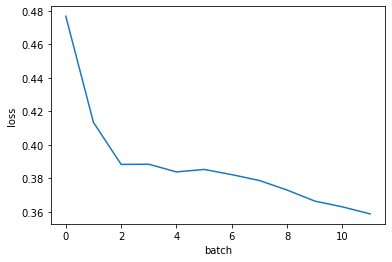

In [72]:
if 'loss' in batchlog_callback.history:
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


In [ ]:
init_states_sample = cell.get_initial_state(batch_size=1)
goal_states = arm.draw_random_uniform_states(batch_size=1)
target_sample = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)


def grad(model, inputs, targets, loss):
  with tf.GradientTape() as tape:
    y_pred = model(inputs, training=False)
    loss_value = loss(y_true=targets, y_pred=y_pred['cartesian position'])
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

def loss_object(y_true, y_pred):
  true_pos, _ = tf.split(y_true, 2, axis=-1)
  pred_pos, _ = tf.split(y_pred, 2, axis=-1)
  return tf.reduce_mean(tf.reduce_sum(tf.abs(true_pos - pred_pos), axis=-1), axis=-1)

l, g = grad(control_rnn, [target_sample, init_states_sample], target_sample, loss_object)
# g

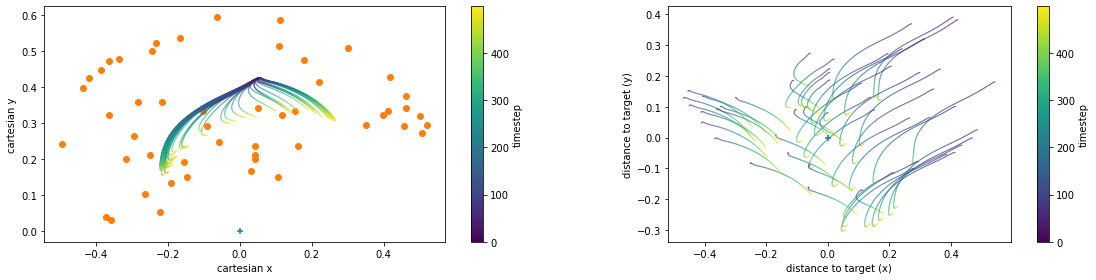

In [25]:
init_states_sample = cell.get_initial_state(
            inputs=cell.plant.draw_fixed_states(position=np.deg2rad([45., 90.]), batch_size=50),
            batch_size=50)
goal_states = arm.draw_random_uniform_states(batch_size=50)
target_sample = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)

results = control_rnn([target_sample, init_states_sample], training=False)

j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(121)
plot_pos_over_time(cart_results=c_results)
plt.scatter(target_sample[:, 0, 0], target_sample[:, 0, 1])

plt.subplot(122)
plot_pos_over_time(cart_results=c_results - target_sample)
plt.xlabel('distance to target (x)')
plt.ylabel('distance to target (y)')
plt.show()

In [ ]:
trial = 1
plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

plt.subplot(141)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle (rad)')

plt.subplot(142)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle velocity (rad/sec)')

plt.subplot(143)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('activation (a.u.)')

plt.subplot(144)
plt.plot(m_results[trial, :, 2, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('muscle velocity (m/sec)')

plt.show()


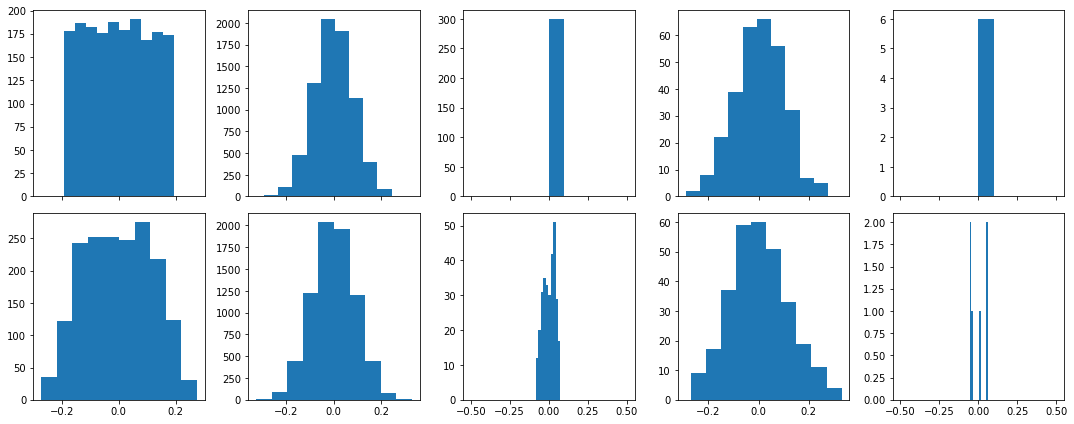

In [54]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-3]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()



In [55]:
### To apply a set of weights from a previous iteration weight set w1
control_rnn.get_layer('RNN').set_weights([w.numpy() for w in w1])

### save model
# name = '50gru_1e-3dt_weights'
# control_rnn.save_weights(os.getcwd() + '/saved_models/' + name)